<a href="https://colab.research.google.com/github/NelsonJQ/termun/blob/main/UN_Term_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install selenium lxml tabulate
!apt-get update
!apt-get install -y chromium-chromedriver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 16.8 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages 

#testing

In [ ]:
# terms to find
TEXT_TO_SEARCH = "UNEP Climate Copenhagen"

import os
import string
from IPython.display import Image
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time

# Create a new directory for the user data
user_data_dir = "/tmp/chrome_user_data"
os.makedirs(user_data_dir, exist_ok=True)

# Set up Chrome options for Google Colab
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument(f'--user-data-dir={user_data_dir}')
options.add_argument('--profile-directory=Profile 2')

# Initialize the WebDriver
driver = webdriver.Chrome(options=options)

try:
    # Step 1: Open the settings page and activate the Spanish checkbox
    driver.get("https://unterm.un.org/unterm2/settings?displayIn=es&searchin=ar&searchin=en&searchin=es&searchin=fr&searchin=ru&searchin=zh")
    wait = WebDriverWait(driver, 1)  # Increase wait time to 5 seconds

    # Print the raw HTML of the settings page
    page_source = driver.page_source
    #print(page_source)

    # Check if the Spanish checkbox is present in the HTML
    if "title=\"Spanish\" type=\"checkbox\" name=\"displayIn\"" not in page_source:
        print("Spanish checkbox not found in the HTML.")

    # Retry mechanism to ensure the checkbox is clickable
    retries = 0
    for attempt in range(retries):
        try:
            spanish_checkbox = wait.until(EC.element_to_be_clickable((By.XPATH, "//input[@title='Spanish' and @name='displayIn']")))
            spanish_checkbox.click()
            print("Spanish checkbox clicked.")
            break
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            time.sleep(2)  # Wait before retrying
        else:
            print("Exception(\"Failed to click the Spanish checkbox after multiple attempts.\")")

    time.sleep(1)  # Wait for the checkbox to be activated

    # Click the "Update Default Settings" button
    try:
        update_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//button[@type='submit' and contains(text(), 'Update Default Settings')]")))
        update_button.click()
        print("Update Default Settings button clicked.")
    except Exception as e:
        print(f"Failed to click the Update Default Settings button: {e}")

except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # Continue even if it fails
    pass

try:
    # Step 1: Go to the search URL with the specified parameters
    search_url = r"https://unterm.un.org/unterm2/en/search?searchTerm=UNEP"
    #search_url = f"https://unterm.un.org/unterm2/en/search?searchTerm={TEXT_TO_SEARCH}&searchType=0&searchLanguages=ar&searchLanguages=en&searchLanguages=es&searchLanguages=fr&searchLanguages=ru&searchLanguages=zh&languagesDisplay=en&languagesDisplay=es&acronymSearch=true&localDBSearch=true&termTitleSearch=true&phraseologySearch=false&footnoteSearch=false&fullTextSearch=false&facetedSearch=false&buildSubjectList=true"
    driver.get(search_url)
    wait = WebDriverWait(driver, 20)  # Increase wait time to 10 seconds

    # Step 2: Click on Advanced Settings

    try:
        advanced_search_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button.btn.text-dark.text-nowrap.btn-link.collapsed")))
        advanced_search_button.click()
    except Exception as e:
        print(f"CSS Failed to search-click the Advanced search button: {e}")
        driver.save_screenshot("/content/screenshot_ERROR_filters.png")
    #try:
     #   advanced_search_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button.btn.text-dark.text-nowrap.btn-link.collapsed")))
      #  driver.execute_script("arguments[0].click();", advanced_search_button)
    #except Exception as e:
     #   print(f"JS Failed to search-click the Advanced search button: {e}")


    time.sleep(2)  # Wait for the advanced search options to be visible

   # Step 3: Activate the Display in: "Spanish" button and other languages
    languages = ["Spanish", "Russian", "Chinese", "Arabic",
                 #"German", "Portuguese"
                 ]
    for lang in languages:
        try:
            lang_button = wait.until(EC.element_to_be_clickable((By.XPATH, f"//button[@id='ds-{lang}' and @aria-pressed='false']")))
            lang_button.click()
            print(f"Display in {lang} button clicked.")
        except Exception as e:
            print(f"Failed to click the Display in {lang} button: {e}")

    driver.save_screenshot("/content/screenshot_filters.png")

    # Step 4: Wait for the table to be visible and scrape its HTML content
    try:
        table = wait.until(EC.visibility_of_element_located((By.XPATH, "//table")))
        #table_html = table.get_dom_attribute('outerHTML')
        table_html = table.get_attribute('outerHTML')
        print("Table HTML content retrieved.")
    except Exception as e:
        print(f"Failed to retrieve the table HTML content: {e}")

except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # Close the WebDriver
    driver.quit()

# Step 5: Convert the table HTML to Markdown
try:
    from io import StringIO
    table_html_io = StringIO(table_html)
    df = pd.read_html(table_html_io)[0]
    markdown_table = df.to_markdown(index=False)
    print(markdown_table)
except Exception as e:
    print(f"Failed to convert the table HTML to Markdown: {e}")
    df

Update Default Settings button clicked.
Display in Spanish button clicked.
Display in Russian button clicked.
Display in Chinese button clicked.
Display in Arabic button clicked.
Table HTML content retrieved.

<ipython-input-10-1df0adbc70b7>:114: DeprecationWarning: using WebElement.get_attribute() has been deprecated. Please use get_dom_attribute() instead.
  table_html = table.get_attribute('outerHTML')



| Unnamed: 0    | English  (Click to sort Ascending)                                                                                       | French  (Click to sort Ascending)                                                                                                                                                                                                                                                            | Spanish  (Click to sort Ascending)                                                                                                                                                                           | Russian  (Click to sort Ascending)                                                                               | Chinese  (Click to sort Ascending)                                                       | Arabic  (Click to sort Ascending)                                                                                                                             

Screenshot of how filters are seen:



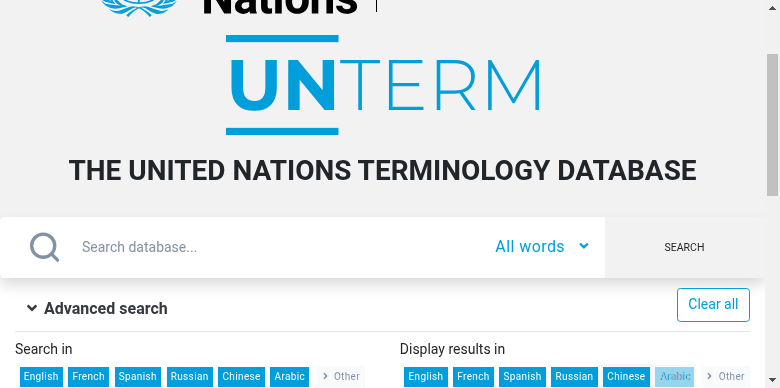

In [ ]:
from IPython.display import Image
#print(table_html)
# Display image of screenshot
image_path = "/content/screenshot_filters.png"
img_error_path = "/content/screenshot_ERROR_filters.png"

print("Screenshot of how filters are seen:\n")
Image(filename=image_path)

#print("\n\nScreenshot of how filters are seen when an error occurs:\n")
#Image(filename=img_error_path)

#Final function

In [ ]:
import os
import string
from IPython.display import Image, display
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
from bs4 import BeautifulSoup

def search_term_and_extract_data(TEXT_TO_SEARCH):
    # Create a new directory for the user data
    user_data_dir = "/tmp/chrome_user_data"
    os.makedirs(user_data_dir, exist_ok=True)

    # Set up Chrome options for Google Colab
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument(f'--user-data-dir={user_data_dir}')
    options.add_argument('--profile-directory=Profile 3')

    # Initialize the WebDriver
    driver = webdriver.Chrome(options=options)

    try:
        # Step 1: Open the settings page and activate the Spanish checkbox
        driver.get("https://unterm.un.org/unterm2/settings?displayIn=es&searchin=ar&searchin=en&searchin=es&searchin=fr&searchin=ru&searchin=zh")
        wait = WebDriverWait(driver, 1)  # Increase wait time to 5 seconds

        # Print the raw HTML of the settings page
        page_source = driver.page_source
        #print(page_source)

        # Check if the Spanish checkbox is present in the HTML
        if "title=\"Spanish\" type=\"checkbox\" name=\"displayIn\"" not in page_source:
            print("Spanish checkbox not found in the HTML.")

        # Retry mechanism to ensure the checkbox is clickable
        retries = 0
        for attempt in range(retries):
            try:
                spanish_checkbox = wait.until(EC.element_to_be_clickable((By.XPATH, "//input[@title='Spanish' and @name='displayIn']")))
                spanish_checkbox.click()
                print("Spanish checkbox clicked.")
                break
            except Exception as e:
                print(f"Attempt {attempt + 1} failed: {e}")
                time.sleep(2)  # Wait before retrying
            else:
                print("Exception(\"Failed to click the Spanish checkbox after multiple attempts.\")")

        time.sleep(1)  # Wait for the checkbox to be activated

        # Click the "Update Default Settings" button
        try:
            update_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//button[@type='submit' and contains(text(), 'Update Default Settings')]")))
            update_button.click()
            print("Update Default Settings button clicked.")
        except Exception as e:
            print(f"Failed to click the Update Default Settings button: {e}")

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        # Continue even if it fails
        pass

    try:
        # Step 1: Go to the search URL with the specified parameters
        search_url = f"https://unterm.un.org/unterm2/en/search?searchTerm={TEXT_TO_SEARCH}&searchType=0&searchLanguages=ar&searchLanguages=en&searchLanguages=es&searchLanguages=fr&searchLanguages=ru&searchLanguages=zh&languagesDisplay=en&languagesDisplay=es&acronymSearch=true&localDBSearch=true&termTitleSearch=true&phraseologySearch=false&footnoteSearch=false&fullTextSearch=false&facetedSearch=false&buildSubjectList=true"
        driver.get(search_url)
        wait = WebDriverWait(driver, 10)  # Increase wait time to 10 seconds

        # Step 2: Click on Advanced Settings
        try:
            advanced_search_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button.btn.text-dark.text-nowrap.btn-link.collapsed")))
            advanced_search_button.click()
        except Exception as e:
            print(f"CSS Failed to search-click the Advanced search button: {e}")
            driver.save_screenshot("/content/screenshot_ERROR_filters.png")

        time.sleep(2)  # Wait for the advanced search options to be visible

        # Step 3: Activate the Display in: "Spanish" button and other languages
        languages = ["Spanish", "Russian", "Chinese", "Arabic"]
        for lang in languages:
            try:
                lang_button = wait.until(EC.element_to_be_clickable((By.XPATH, f"//button[@id='ds-{lang}' and @aria-pressed='false']")))
                lang_button.click()
                print(f"Display in {lang} button clicked.")
            except Exception as e:
                print(f"Failed to click the Display in {lang} button: {e}")

        driver.save_screenshot("/content/screenshot_filters.png")

        # Step 4: Wait for the table to be visible and scrape its HTML content
        try:
            table = wait.until(EC.visibility_of_element_located((By.XPATH, "//table")))
            table_html = table.get_attribute('outerHTML')
            print("Table HTML content retrieved.")
        except Exception as e:
            print(f"Failed to retrieve the table HTML content: {e}")

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        # Close the WebDriver
        driver.quit()

    # Step 5: Convert the table HTML to a dictionary
    try:
        soup = BeautifulSoup(table_html, 'html.parser')
        rows = soup.find_all('tr')
        data = []
        for row in rows:
            cols = row.find_all('td')
            if len(cols) > 0:
                row_data = {}
                for col, lang in zip(cols[1:], ["English", "French", "Spanish", "Russian", "Chinese", "Arabic"]):
                    terms = []
                    ul = col.find('ul', class_='search-result')
                    if ul:
                        for li in ul.find_all('li'):
                            span = li.find('span', class_=True, lang=True)
                            if span:
                                term = span.get_text(strip=False)
                                term_class = span['class'][0]
                                terms.append({"term": term, "termClass": term_class})
                    row_data[lang] = terms

                # Extract source information
                source_div = cols[-1].find('div', class_='record-info')
                if source_div:
                    source = source_div.find('h5').get_text(strip=False)
                    tags = [li.get_text(strip=False) for li in source_div.find_all('li')]
                    row_data["UNTerm_Source"] = {"source": source, "tags": tags}
                else:
                    row_data["UNTerm_Source"] = {"source": "", "tags": []}

                data.append(row_data)
        table_html_io = StringIO(table_html)
        df = pd.read_html(table_html_io)[0]
        markdown_table = df.to_markdown(index=False)
        #print(markdown_table)
        data_df = pd.DataFrame(data)

        return data, markdown_table, table_html, df, data_df
    except Exception as e:
        print(f"Failed to convert the table HTML to a dictionary: {e}")
        return []

# Example usage
TEXT_TO_SEARCH = "earmarked funds"
data, markdown_table, table_html, df, data_df = search_term_and_extract_data(TEXT_TO_SEARCH)
print("\n\nDATA")
print(data)
print("\n\nMARKDOWN TABLE")
print(markdown_table)
print("\n\nTABLE HTML")
print(table_html)
print("\n\nDATAFRAME")
df

Update Default Settings button clicked.
Display in Spanish button clicked.
Display in Russian button clicked.
Display in Chinese button clicked.
Display in Arabic button clicked.


<ipython-input-28-d8bd96d8cad2>:102: DeprecationWarning: using WebElement.get_attribute() has been deprecated. Please use get_dom_attribute() instead.
  table_html = table.get_attribute('outerHTML')


Table HTML content retrieved.


DATA
[{'English': [{'term': 'earmarked funds', 'termClass': 'preferred'}], 'French': [{'term': 'fonds préaffectés', 'termClass': 'preferred'}], 'Spanish': [{'term': 'fondos asignados a fines específicos', 'termClass': 'superseded'}, {'term': 'fondos para fines específicos', 'termClass': 'superseded'}, {'term': 'fondos afectados', 'termClass': 'preferred'}], 'Russian': [], 'Chinese': [{'term': '专用资金', 'termClass': 'admitted'}, {'term': '专用基金', 'termClass': 'preferred'}], 'Arabic': [{'term': 'أموال مخصصة', 'termClass': 'preferred'}], 'UNTerm_Source': {'source': 'UNHQ', 'tags': ['Budget']}}, {'English': [{'term': 'Foundation earmarked', 'termClass': 'admitted'}, {'term': 'Foundation earmarked funds', 'termClass': 'preferred'}], 'French': [{'term': 'fonds préaffectés de la Fondation', 'termClass': 'preferred'}], 'Spanish': [], 'Russian': [{'term': 'Средства Фонда, целевая часть', 'termClass': 'preferred'}], 'Chinese': [], 'Arabic': [], 'UNTerm_Source': {'sou

,Unnamed: 0,English (Click to sort Ascending),French (Click to sort Ascending),Spanish (Click to sort Ascending),Russian (Click to sort Ascending),Chinese (Click to sort Ascending),Arabic (Click to sort Ascending),Unnamed: 7
0,Open Details,earmarked funds,fonds préaffectés,fondos asignados a fines específicos fondos para fines específicos fondos afectados,NaN,专用资金 专用基金,أموال مخصصة,UNHQ Budget
1,Open Details,Foundation earmarked Foundation earmarked funds,fonds préaffectés de la Fondation,NaN,"Средства Фонда, целевая часть",NaN,NaN,UNON UN-HABITAT Finance for development
2,Open Details,management of trust funds and earmarked contributions,NaN,NaN,распоряжение целевыми фондами и целевыми взносами,NaN,NaN,UNON
3,Open Details,non-earmarked funds unearmarked funds,fonds non préaffectés fonds non affectés à des fins spéciales fonds non affectés à des fins particulières,fondos no afectados fondos para fines generales fondos no asignados a fines específicos,NaN,NaN,NaN,UNHQ Budget


In [ ]:
data_df = pd.DataFrame(data)
#full display
pd.set_option('display.max_colwidth', None)
spanish_value = data_df["Spanish"][0]
repr(spanish_value)
data_df


,English,French,Spanish,Russian,Chinese,Arabic,UNTerm_Source
0,"[{'term': 'earmarked funds', 'termClass': 'preferred'}]","[{'term': 'fonds préaffectés', 'termClass': 'preferred'}]","[{'term': 'fondos asignados a fines específicos', 'termClass': 'superseded'}, {'term': 'fondos para fines específicos', 'termClass': 'superseded'}, {'term': 'fondos afectados', 'termClass': 'preferred'}]",[],"[{'term': '专用资金', 'termClass': 'admitted'}, {'term': '专用基金', 'termClass': 'preferred'}]","[{'term': 'أموال مخصصة', 'termClass': 'preferred'}]","{'source': 'UNHQ', 'tags': ['Budget']}"
1,"[{'term': 'Foundation earmarked', 'termClass': 'admitted'}, {'term': 'Foundation earmarked funds', 'termClass': 'preferred'}]","[{'term': 'fonds préaffectés de la Fondation', 'termClass': 'preferred'}]",[],"[{'term': 'Средства Фонда, целевая часть', 'termClass': 'preferred'}]",[],[],"{'source': 'UNON', 'tags': ['UN-HABITAT', 'Finance for development']}"
2,"[{'term': 'management of trust funds and earmarked contributions', 'termClass': 'preferred'}]",[],[],"[{'term': 'распоряжение целевыми фондами и целевыми взносами', 'termClass': 'preferred'}]",[],[],"{'source': 'UNON', 'tags': []}"
3,"[{'term': 'non-earmarked funds', 'termClass': 'admitted'}, {'term': 'unearmarked funds', 'termClass': 'preferred'}]","[{'term': 'fonds non préaffectés', 'termClass': 'preferred'}, {'term': 'fonds non affectés à des fins spéciales', 'termClass': 'admitted'}, {'term': 'fonds non affectés à des fins particulières', 'termClass': 'admitted'}]","[{'term': 'fondos no afectados', 'termClass': 'preferred'}, {'term': 'fondos para fines generales', 'termClass': 'superseded'}, {'term': 'fondos no asignados a fines específicos', 'termClass': 'superseded'}]",[],[],[],"{'source': 'UNHQ', 'tags': ['Budget']}"


In [ ]:
df

,Unnamed: 0,English (Click to sort Ascending),French (Click to sort Ascending),Spanish (Click to sort Ascending),Russian (Click to sort Ascending),Chinese (Click to sort Ascending),Arabic (Click to sort Ascending),Unnamed: 7
0,Open Details,United Nations Environment Programme Copenhagen Climate Centre UNEP Copenhagen Climate Centre,Centre pour le climat du Programme des Nations Unies pour l'environnement à Copenhague Centre pour le climat du PNUE à Copenhague,NaN,NaN,环境署哥本哈根气候中心 联合国环境规划署哥本哈根气候中心,مركز كوبنهاغن للمناخ التابع لبرنامج الأمم المتحدة للبيئة,UNOG UNEP Environment (general)Organizational structure


In [ ]:
# print Spanish value in df_result
spanish_value = df_result["Spanish"][0]
# print raw string
print(spanish_value)
# print string as raw
print(repr(spanish_value))

Emissions Gap Report informe sobre la brecha de emisiones
'Emissions Gap Report informe sobre la brecha de emisiones'
